In [1]:
import pandas as pd
import torch
import sklearn
import numpy as np

import transformers

c:\Users\robin\anaconda3\envs\dnabert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

In [3]:
modelpath = "zhihan1996/DNABERT-2-117M"
df = pd.read_csv("./sample_data/esp_decoded.csv")

print(df.info())

print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56888 entries, 0 to 56887
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seq     56888 non-null  object 
 1   y       56888 non-null  float64
dtypes: float64(1), object(1)
memory usage: 889.0+ KB
None
                     seq         y
0  AAAAAAAAACTCCAAAACCCT  0.093147
1  AAAAAACAACAAGAAGCACAA  0.064951
2  AAAAAACACAAGCAAGACCGT  0.061797
3  AAAAAACAGATGCCACCTGTG  0.057246
4  AAAAAACCCGTAGATAGCCTC  0.067596


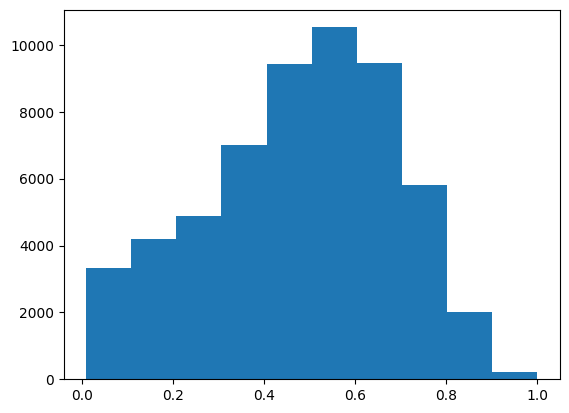

In [4]:
import matplotlib.pyplot as plt

#plot label distribution
plt.hist(df['y'])
plt.show()

In [5]:
import datasets

#turn df into a dataset
raw_dataset = datasets.Dataset.from_pandas(df)

In [6]:
#raw_datasets = raw_dataset.train_test_split(test_size=0.2)

print(raw_dataset)

Dataset({
    features: ['seq', 'y'],
    num_rows: 56888
})


In [7]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
        modelpath,
        
        model_max_length=100,
        padding_side="right",
        use_fast=True,
        trust_remote_code=True,
    )

In [8]:
from transformers import DataCollatorWithPadding

def tokenize_function(example):
    return tokenizer(example["seq"], truncation=True)

tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format("torch")

#print(output)
print(tokenized_dataset)

Map: 100%|██████████| 56888/56888 [00:01<00:00, 40738.23 examples/s]

Dataset({
    features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 56888
})


In [9]:
#split into train and validation set
tokenized_datasets = tokenized_dataset.train_test_split(test_size=0.2)

In [10]:
print(tokenized_datasets)

tokenized_datasets = tokenized_datasets.remove_columns(["seq"])
tokenized_datasets = tokenized_datasets.rename_column("y", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names


DatasetDict({
    train: Dataset({
        features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 45510
    })
    test: Dataset({
        features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11378
    })
})


['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [11]:
from torch.utils.data import DataLoader

batch_size = 128

print(tokenizer.pad_token_id)
print(tokenizer.model_max_length)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt", padding="longest", max_length=tokenizer.model_max_length)




3
100


In [21]:
# train_dataloader = DataLoader(
#     tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
# )
eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
)

In [12]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    modelpath,
    cache_dir=None,
    num_labels=1,
    trust_remote_code=True,
    ignore_mismatched_sizes=True
)

model.cuda()

C:\Users\robin/.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\1d020b803b871a976f5f3d5565f0eac8f2c7bb81\bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_feat

In [13]:
# for batch in train_dataloader:
#     print(batch['labels'][0])
#     break
# print({k: v.shape for k, v in batch.items()})

In [14]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    logits = logits[0]

    print(type(labels))
    print(type(logits))
    print(labels)
    print(logits)
    print(labels.shape)
    print(logits.shape)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

In [15]:
from transformers import Trainer, TrainingArguments

# Specifiy the arguments for the trainer  
training_args = TrainingArguments(
    output_dir ='./results',          
    num_train_epochs = 3,     
    per_device_train_batch_size = 128,   
    per_device_eval_batch_size = 32,   
    weight_decay = 0.01,               
    learning_rate = 3e-5,
    logging_dir = './logs',
    logging_steps = 10,        
    save_total_limit = 10,
    load_best_model_at_end = True,     
    #metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
) 

# Call the Trainer
trainer = Trainer(
    model = model,                         
    args = training_args,                  
    train_dataset = tokenized_datasets["train"],         
    eval_dataset = tokenized_datasets["test"],          
    #compute_metrics = compute_metrics,
    data_collator = data_collator, 
)

# Train the model
trainer.train()

# Call the summary
trainer.evaluate()

c:\Users\robin\anaconda3\envs\dnabert\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  1%|          | 10/1068 [00:26<48:42,  2.76s/it]

{'loss': 0.0813, 'learning_rate': 2.9719101123595505e-05, 'epoch': 0.03}


  2%|▏         | 20/1068 [00:54<46:57,  2.69s/it]

{'loss': 0.0488, 'learning_rate': 2.9438202247191012e-05, 'epoch': 0.06}


  3%|▎         | 30/1068 [01:22<50:13,  2.90s/it]

{'loss': 0.0447, 'learning_rate': 2.915730337078652e-05, 'epoch': 0.08}


  4%|▎         | 40/1068 [01:49<45:45,  2.67s/it]

{'loss': 0.0433, 'learning_rate': 2.8876404494382023e-05, 'epoch': 0.11}


  5%|▍         | 50/1068 [02:15<45:09,  2.66s/it]

{'loss': 0.0381, 'learning_rate': 2.859550561797753e-05, 'epoch': 0.14}


  6%|▌         | 60/1068 [02:42<44:49,  2.67s/it]

{'loss': 0.038, 'learning_rate': 2.8314606741573034e-05, 'epoch': 0.17}


  7%|▋         | 70/1068 [03:09<44:25,  2.67s/it]

{'loss': 0.037, 'learning_rate': 2.8033707865168537e-05, 'epoch': 0.2}


  7%|▋         | 80/1068 [03:36<43:56,  2.67s/it]

{'loss': 0.0369, 'learning_rate': 2.7752808988764048e-05, 'epoch': 0.22}


  8%|▊         | 90/1068 [04:03<43:25,  2.66s/it]

{'loss': 0.0366, 'learning_rate': 2.7471910112359552e-05, 'epoch': 0.25}


  9%|▉         | 100/1068 [04:29<42:46,  2.65s/it]

{'loss': 0.0353, 'learning_rate': 2.7191011235955055e-05, 'epoch': 0.28}


 10%|█         | 110/1068 [04:57<43:29,  2.72s/it]

{'loss': 0.0342, 'learning_rate': 2.6910112359550563e-05, 'epoch': 0.31}


 11%|█         | 120/1068 [05:23<42:11,  2.67s/it]

{'loss': 0.0334, 'learning_rate': 2.6629213483146066e-05, 'epoch': 0.34}


 12%|█▏        | 130/1068 [05:50<41:48,  2.67s/it]

{'loss': 0.0386, 'learning_rate': 2.6348314606741574e-05, 'epoch': 0.37}


 13%|█▎        | 140/1068 [06:17<41:45,  2.70s/it]

{'loss': 0.0368, 'learning_rate': 2.606741573033708e-05, 'epoch': 0.39}


 14%|█▍        | 150/1068 [06:44<41:56,  2.74s/it]

{'loss': 0.0357, 'learning_rate': 2.5786516853932585e-05, 'epoch': 0.42}


 15%|█▍        | 160/1068 [07:11<40:59,  2.71s/it]

{'loss': 0.0351, 'learning_rate': 2.5505617977528088e-05, 'epoch': 0.45}


 16%|█▌        | 170/1068 [07:38<39:55,  2.67s/it]

{'loss': 0.0352, 'learning_rate': 2.52247191011236e-05, 'epoch': 0.48}


 17%|█▋        | 180/1068 [08:04<39:27,  2.67s/it]

{'loss': 0.0356, 'learning_rate': 2.4943820224719103e-05, 'epoch': 0.51}


 18%|█▊        | 190/1068 [08:32<40:44,  2.78s/it]

{'loss': 0.0355, 'learning_rate': 2.4662921348314606e-05, 'epoch': 0.53}


 19%|█▊        | 200/1068 [08:59<39:27,  2.73s/it]

{'loss': 0.034, 'learning_rate': 2.4382022471910114e-05, 'epoch': 0.56}


 20%|█▉        | 210/1068 [09:26<38:55,  2.72s/it]

{'loss': 0.0347, 'learning_rate': 2.4101123595505617e-05, 'epoch': 0.59}


 21%|██        | 220/1068 [09:54<38:29,  2.72s/it]

{'loss': 0.0353, 'learning_rate': 2.3820224719101125e-05, 'epoch': 0.62}


 22%|██▏       | 230/1068 [10:22<38:41,  2.77s/it]

{'loss': 0.0363, 'learning_rate': 2.353932584269663e-05, 'epoch': 0.65}


 22%|██▏       | 240/1068 [10:50<38:28,  2.79s/it]

{'loss': 0.0327, 'learning_rate': 2.3258426966292135e-05, 'epoch': 0.67}


 23%|██▎       | 250/1068 [11:18<37:22,  2.74s/it]

{'loss': 0.032, 'learning_rate': 2.297752808988764e-05, 'epoch': 0.7}


 24%|██▍       | 260/1068 [11:45<36:57,  2.74s/it]

{'loss': 0.0339, 'learning_rate': 2.2696629213483146e-05, 'epoch': 0.73}


 25%|██▌       | 270/1068 [12:13<36:43,  2.76s/it]

{'loss': 0.0324, 'learning_rate': 2.2415730337078654e-05, 'epoch': 0.76}


 26%|██▌       | 280/1068 [12:41<36:04,  2.75s/it]

{'loss': 0.0335, 'learning_rate': 2.2134831460674157e-05, 'epoch': 0.79}


 27%|██▋       | 290/1068 [13:09<35:48,  2.76s/it]

{'loss': 0.0357, 'learning_rate': 2.1853932584269665e-05, 'epoch': 0.81}


 28%|██▊       | 300/1068 [13:37<36:17,  2.84s/it]

{'loss': 0.033, 'learning_rate': 2.1573033707865168e-05, 'epoch': 0.84}


 29%|██▉       | 310/1068 [14:05<34:54,  2.76s/it]

{'loss': 0.0325, 'learning_rate': 2.1292134831460672e-05, 'epoch': 0.87}


 30%|██▉       | 320/1068 [14:32<34:38,  2.78s/it]

{'loss': 0.0306, 'learning_rate': 2.1011235955056183e-05, 'epoch': 0.9}


 31%|███       | 330/1068 [15:00<33:57,  2.76s/it]

{'loss': 0.0317, 'learning_rate': 2.0730337078651686e-05, 'epoch': 0.93}


 32%|███▏      | 340/1068 [15:28<33:37,  2.77s/it]

{'loss': 0.031, 'learning_rate': 2.044943820224719e-05, 'epoch': 0.96}


 33%|███▎      | 350/1068 [15:55<33:04,  2.76s/it]

{'loss': 0.0315, 'learning_rate': 2.0168539325842697e-05, 'epoch': 0.98}


                                                  
 33%|███▎      | 356/1068 [16:37<26:38,  2.25s/it]

{'eval_loss': 0.029122376814484596, 'eval_runtime': 26.5461, 'eval_samples_per_second': 428.614, 'eval_steps_per_second': 13.411, 'epoch': 1.0}


 34%|███▎      | 360/1068 [16:52<1:08:00,  5.76s/it]

{'loss': 0.0323, 'learning_rate': 1.98876404494382e-05, 'epoch': 1.01}


 35%|███▍      | 370/1068 [17:20<34:08,  2.94s/it]  

{'loss': 0.0298, 'learning_rate': 1.9606741573033708e-05, 'epoch': 1.04}


 36%|███▌      | 380/1068 [17:48<32:35,  2.84s/it]

{'loss': 0.0309, 'learning_rate': 1.9325842696629215e-05, 'epoch': 1.07}


 37%|███▋      | 390/1068 [18:16<31:17,  2.77s/it]

{'loss': 0.0299, 'learning_rate': 1.904494382022472e-05, 'epoch': 1.1}


 37%|███▋      | 400/1068 [18:44<31:04,  2.79s/it]

{'loss': 0.0304, 'learning_rate': 1.8764044943820223e-05, 'epoch': 1.12}


 38%|███▊      | 410/1068 [19:11<29:53,  2.73s/it]

{'loss': 0.0293, 'learning_rate': 1.848314606741573e-05, 'epoch': 1.15}


 39%|███▉      | 420/1068 [19:39<29:34,  2.74s/it]

{'loss': 0.0299, 'learning_rate': 1.8202247191011237e-05, 'epoch': 1.18}


 40%|████      | 430/1068 [20:08<29:38,  2.79s/it]

{'loss': 0.0285, 'learning_rate': 1.792134831460674e-05, 'epoch': 1.21}


 41%|████      | 440/1068 [20:36<29:02,  2.77s/it]

{'loss': 0.0314, 'learning_rate': 1.7640449438202248e-05, 'epoch': 1.24}


 42%|████▏     | 450/1068 [21:03<28:07,  2.73s/it]

{'loss': 0.031, 'learning_rate': 1.7359550561797752e-05, 'epoch': 1.26}


 43%|████▎     | 460/1068 [21:31<27:51,  2.75s/it]

{'loss': 0.0271, 'learning_rate': 1.7078651685393256e-05, 'epoch': 1.29}


 44%|████▍     | 470/1068 [22:00<28:19,  2.84s/it]

{'loss': 0.0298, 'learning_rate': 1.6797752808988766e-05, 'epoch': 1.32}


 45%|████▍     | 480/1068 [22:27<26:58,  2.75s/it]

{'loss': 0.0287, 'learning_rate': 1.651685393258427e-05, 'epoch': 1.35}


 46%|████▌     | 490/1068 [22:56<26:57,  2.80s/it]

{'loss': 0.0288, 'learning_rate': 1.6235955056179774e-05, 'epoch': 1.38}


 47%|████▋     | 500/1068 [23:23<25:54,  2.74s/it]

{'loss': 0.0288, 'learning_rate': 1.595505617977528e-05, 'epoch': 1.4}


 48%|████▊     | 510/1068 [23:52<26:03,  2.80s/it]

{'loss': 0.0274, 'learning_rate': 1.5674157303370788e-05, 'epoch': 1.43}


 49%|████▊     | 520/1068 [24:21<26:09,  2.86s/it]

{'loss': 0.0283, 'learning_rate': 1.5393258426966292e-05, 'epoch': 1.46}


 50%|████▉     | 530/1068 [24:49<25:11,  2.81s/it]

{'loss': 0.0301, 'learning_rate': 1.51123595505618e-05, 'epoch': 1.49}


 51%|█████     | 540/1068 [25:17<24:41,  2.81s/it]

{'loss': 0.0273, 'learning_rate': 1.4831460674157303e-05, 'epoch': 1.52}


 51%|█████▏    | 550/1068 [25:46<24:36,  2.85s/it]

{'loss': 0.0284, 'learning_rate': 1.455056179775281e-05, 'epoch': 1.54}


 52%|█████▏    | 560/1068 [26:17<24:47,  2.93s/it]

{'loss': 0.0293, 'learning_rate': 1.4269662921348316e-05, 'epoch': 1.57}


 53%|█████▎    | 570/1068 [26:46<24:19,  2.93s/it]

{'loss': 0.0264, 'learning_rate': 1.398876404494382e-05, 'epoch': 1.6}


 54%|█████▍    | 580/1068 [27:15<23:14,  2.86s/it]

{'loss': 0.0296, 'learning_rate': 1.3707865168539327e-05, 'epoch': 1.63}


 55%|█████▌    | 590/1068 [27:43<22:20,  2.80s/it]

{'loss': 0.0294, 'learning_rate': 1.3426966292134832e-05, 'epoch': 1.66}


 56%|█████▌    | 600/1068 [28:11<22:12,  2.85s/it]

{'loss': 0.0286, 'learning_rate': 1.3146067415730338e-05, 'epoch': 1.69}


 57%|█████▋    | 610/1068 [28:41<21:55,  2.87s/it]

{'loss': 0.0272, 'learning_rate': 1.2865168539325843e-05, 'epoch': 1.71}


 58%|█████▊    | 620/1068 [29:10<21:12,  2.84s/it]

{'loss': 0.0258, 'learning_rate': 1.258426966292135e-05, 'epoch': 1.74}


 59%|█████▉    | 630/1068 [29:38<20:25,  2.80s/it]

{'loss': 0.0282, 'learning_rate': 1.2303370786516854e-05, 'epoch': 1.77}


 60%|█████▉    | 640/1068 [30:06<19:46,  2.77s/it]

{'loss': 0.026, 'learning_rate': 1.202247191011236e-05, 'epoch': 1.8}


 61%|██████    | 650/1068 [30:34<19:18,  2.77s/it]

{'loss': 0.0277, 'learning_rate': 1.1741573033707867e-05, 'epoch': 1.83}


 62%|██████▏   | 660/1068 [31:02<19:11,  2.82s/it]

{'loss': 0.0285, 'learning_rate': 1.146067415730337e-05, 'epoch': 1.85}


 63%|██████▎   | 670/1068 [31:32<20:01,  3.02s/it]

{'loss': 0.0264, 'learning_rate': 1.1179775280898877e-05, 'epoch': 1.88}


 64%|██████▎   | 680/1068 [32:00<18:17,  2.83s/it]

{'loss': 0.0263, 'learning_rate': 1.0898876404494383e-05, 'epoch': 1.91}


 65%|██████▍   | 690/1068 [32:29<17:46,  2.82s/it]

{'loss': 0.0277, 'learning_rate': 1.0617977528089887e-05, 'epoch': 1.94}


 66%|██████▌   | 700/1068 [32:59<18:37,  3.04s/it]

{'loss': 0.0266, 'learning_rate': 1.0337078651685394e-05, 'epoch': 1.97}


 66%|██████▋   | 710/1068 [33:27<16:37,  2.79s/it]

{'loss': 0.0293, 'learning_rate': 1.00561797752809e-05, 'epoch': 1.99}


                                                  
 67%|██████▋   | 712/1068 [33:58<13:30,  2.28s/it]

{'eval_loss': 0.02724052406847477, 'eval_runtime': 27.7836, 'eval_samples_per_second': 409.523, 'eval_steps_per_second': 12.813, 'epoch': 2.0}


 67%|██████▋   | 720/1068 [34:25<21:15,  3.66s/it]  

{'loss': 0.0246, 'learning_rate': 9.775280898876405e-06, 'epoch': 2.02}


 68%|██████▊   | 730/1068 [34:54<16:14,  2.88s/it]

{'loss': 0.0265, 'learning_rate': 9.49438202247191e-06, 'epoch': 2.05}


 69%|██████▉   | 740/1068 [35:22<15:41,  2.87s/it]

{'loss': 0.0238, 'learning_rate': 9.213483146067416e-06, 'epoch': 2.08}


 70%|███████   | 750/1068 [35:53<15:57,  3.01s/it]

{'loss': 0.0273, 'learning_rate': 8.932584269662921e-06, 'epoch': 2.11}


 71%|███████   | 760/1068 [36:21<14:27,  2.82s/it]

{'loss': 0.025, 'learning_rate': 8.651685393258427e-06, 'epoch': 2.13}


 72%|███████▏  | 770/1068 [36:50<14:14,  2.87s/it]

{'loss': 0.025, 'learning_rate': 8.370786516853934e-06, 'epoch': 2.16}


 73%|███████▎  | 780/1068 [37:20<14:08,  2.95s/it]

{'loss': 0.0252, 'learning_rate': 8.089887640449438e-06, 'epoch': 2.19}


 74%|███████▍  | 790/1068 [37:52<15:35,  3.36s/it]

{'loss': 0.0253, 'learning_rate': 7.808988764044945e-06, 'epoch': 2.22}


 75%|███████▍  | 800/1068 [38:20<12:45,  2.86s/it]

{'loss': 0.026, 'learning_rate': 7.5280898876404495e-06, 'epoch': 2.25}


 76%|███████▌  | 810/1068 [38:49<12:28,  2.90s/it]

{'loss': 0.0247, 'learning_rate': 7.247191011235956e-06, 'epoch': 2.28}


 77%|███████▋  | 820/1068 [39:18<11:45,  2.84s/it]

{'loss': 0.0258, 'learning_rate': 6.966292134831461e-06, 'epoch': 2.3}


 78%|███████▊  | 830/1068 [39:49<11:34,  2.92s/it]

{'loss': 0.0268, 'learning_rate': 6.685393258426966e-06, 'epoch': 2.33}


 79%|███████▊  | 840/1068 [40:18<11:04,  2.91s/it]

{'loss': 0.027, 'learning_rate': 6.404494382022472e-06, 'epoch': 2.36}


 80%|███████▉  | 850/1068 [40:47<10:33,  2.91s/it]

{'loss': 0.0258, 'learning_rate': 6.123595505617978e-06, 'epoch': 2.39}


 81%|████████  | 860/1068 [41:15<09:51,  2.84s/it]

{'loss': 0.0239, 'learning_rate': 5.842696629213483e-06, 'epoch': 2.42}


 81%|████████▏ | 870/1068 [41:44<09:35,  2.91s/it]

{'loss': 0.0248, 'learning_rate': 5.5617977528089895e-06, 'epoch': 2.44}


 82%|████████▏ | 880/1068 [42:13<08:52,  2.83s/it]

{'loss': 0.024, 'learning_rate': 5.280898876404495e-06, 'epoch': 2.47}


 83%|████████▎ | 890/1068 [42:41<08:20,  2.81s/it]

{'loss': 0.0239, 'learning_rate': 4.9999999999999996e-06, 'epoch': 2.5}


 84%|████████▍ | 900/1068 [43:12<08:22,  2.99s/it]

{'loss': 0.0234, 'learning_rate': 4.719101123595506e-06, 'epoch': 2.53}


 85%|████████▌ | 910/1068 [43:42<07:41,  2.92s/it]

{'loss': 0.0254, 'learning_rate': 4.438202247191011e-06, 'epoch': 2.56}


 86%|████████▌ | 920/1068 [44:10<06:52,  2.79s/it]

{'loss': 0.0249, 'learning_rate': 4.157303370786517e-06, 'epoch': 2.58}


 87%|████████▋ | 930/1068 [44:39<06:31,  2.84s/it]

{'loss': 0.0248, 'learning_rate': 3.876404494382023e-06, 'epoch': 2.61}


 88%|████████▊ | 940/1068 [45:08<06:01,  2.82s/it]

{'loss': 0.0241, 'learning_rate': 3.595505617977528e-06, 'epoch': 2.64}


 89%|████████▉ | 950/1068 [45:37<05:47,  2.94s/it]

{'loss': 0.0234, 'learning_rate': 3.314606741573034e-06, 'epoch': 2.67}


 90%|████████▉ | 960/1068 [46:05<04:55,  2.74s/it]

{'loss': 0.0267, 'learning_rate': 3.033707865168539e-06, 'epoch': 2.7}


 91%|█████████ | 970/1068 [46:34<04:47,  2.94s/it]

{'loss': 0.0261, 'learning_rate': 2.752808988764045e-06, 'epoch': 2.72}


 92%|█████████▏| 980/1068 [47:02<04:09,  2.83s/it]

{'loss': 0.0233, 'learning_rate': 2.4719101123595505e-06, 'epoch': 2.75}


 93%|█████████▎| 990/1068 [47:31<03:42,  2.85s/it]

{'loss': 0.025, 'learning_rate': 2.191011235955056e-06, 'epoch': 2.78}


 94%|█████████▎| 1000/1068 [48:00<03:10,  2.80s/it]

{'loss': 0.0258, 'learning_rate': 1.910112359550562e-06, 'epoch': 2.81}


 95%|█████████▍| 1010/1068 [48:28<02:44,  2.83s/it]

{'loss': 0.0236, 'learning_rate': 1.6292134831460675e-06, 'epoch': 2.84}


 96%|█████████▌| 1020/1068 [48:56<02:16,  2.84s/it]

{'loss': 0.0213, 'learning_rate': 1.348314606741573e-06, 'epoch': 2.87}


 96%|█████████▋| 1030/1068 [49:26<01:53,  2.98s/it]

{'loss': 0.0243, 'learning_rate': 1.0674157303370785e-06, 'epoch': 2.89}


 97%|█████████▋| 1040/1068 [49:54<01:20,  2.88s/it]

{'loss': 0.0257, 'learning_rate': 7.865168539325844e-07, 'epoch': 2.92}


 98%|█████████▊| 1050/1068 [50:23<00:51,  2.85s/it]

{'loss': 0.0256, 'learning_rate': 5.056179775280899e-07, 'epoch': 2.95}


 99%|█████████▉| 1060/1068 [50:52<00:23,  2.89s/it]

{'loss': 0.024, 'learning_rate': 2.247191011235955e-07, 'epoch': 2.98}


                                                   
100%|██████████| 1068/1068 [51:41<00:00,  2.33s/it]

{'eval_loss': 0.0243062861263752, 'eval_runtime': 27.3885, 'eval_samples_per_second': 415.43, 'eval_steps_per_second': 12.998, 'epoch': 3.0}


100%|██████████| 1068/1068 [51:45<00:00,  2.91s/it]


{'train_runtime': 3105.1956, 'train_samples_per_second': 43.968, 'train_steps_per_second': 0.344, 'train_loss': 0.030119813183385333, 'epoch': 3.0}


100%|██████████| 356/356 [00:27<00:00, 13.05it/s]


{'eval_loss': 0.0243062861263752,
 'eval_runtime': 27.3871,
 'eval_samples_per_second': 415.451,
 'eval_steps_per_second': 12.999,
 'epoch': 3.0}

In [39]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from tqdm.auto import tqdm

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    logits = logits[0]

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    modelpath,
    cache_dir=None,
    num_labels=1,
    trust_remote_code=True,
)

model.cuda()

#metric = evaluate.load("accuracy")
#model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}

    labels = batch["labels"].reshape(-1, 1)

    with torch.no_grad():
        outputs = model(**batch)
    
    #calculate metrics

    logits = outputs["logits"]
    
    #use cpu to calculate metrics
    logits = logits.cpu()
    labels = labels.cpu()

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    #smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)
    print(logits[:5])
    print(labels[:5])

    print("mse: ", mse, " rmse: ", rmse, " mae: ", mae, " r2: ", r2)
    break


#metric.compute()

#trained

# tensor([[0.5489],
#         [0.3944],
#         [0.7925],
#         [0.4906],
#         [0.5423]])
# tensor([[0.6034],
#         [0.5854],
#         [0.7205],
#         [0.1395],
#         [0.5100]])
# mse:  0.031777926  rmse:  0.17826363  mae:  0.13696145  r2:  0.25551206762590795

#untrained

# tensor([[-0.0495],
#         [ 0.0050],
#         [ 0.0346],
#         [ 0.1536],
#         [-0.0072]])
# tensor([[0.6034],
#         [0.5854],
#         [0.7205],
#         [0.1395],
#         [0.5100]])
# mse:  0.2381744  rmse:  0.48803115  mae:  0.440737  r2:  -4.579909511011868

C:\Users\robin/.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\1d020b803b871a976f5f3d5565f0eac8f2c7bb81\bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassi

tensor([[-0.0495],
        [ 0.0050],
        [ 0.0346],
        [ 0.1536],
        [-0.0072]])
tensor([[0.6034],
        [0.5854],
        [0.7205],
        [0.1395],
        [0.5100]])
mse:  0.2381744  rmse:  0.48803115  mae:  0.440737  r2:  -4.579909511011868
